In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')

class TF_fitting():
    def __init__(self, data):
        self.data=data
        self.u0 = self.data.loc[0,"U"]
        self.yp0 = self.data.loc[0,"y"]
        self.t = self.data[['Time']].values.reshape(-1)
        self.u = self.data[['U']].values.reshape(-1)
        self.yp = self.data[['y']].values.reshape(-1)
        # specify number of steps
        self.ns = len(self.t)
        self.delta_t = self.t[1]-self.t[0]
        # create linear interpolation of the u data versus time
        self.uf = interp1d(self.t,self.u)

    # define first-order plus dead-time approximation    
    def fopdt(self,y,t,Km,taum,thetam):
        # arguments
        #  y      = output
        #  t      = time
        #  uf     = input linear function (for time shift)
        #  Km     = model gain
        #  taum   = model time constant
        #  thetam = model time constant
        # time-shift u
        try:
            if (t-thetam) <= 0:
                um = self.uf(0.0)
            else:
                um = self.uf(t-thetam)
        except:
            #print('Error with time extrapolation: ' + str(t))
            um = self.u0
        # calculate derivative
        dydt = (-(y-self.yp0) + Km * (um-self.u0))/taum
        return dydt     
        
    # simulate FOPDT model with x=[Km,taum,thetam]
    def sim_model(self,x):
        # input arguments
        Km = x[0]
        taum = x[1]
        thetam = x[2]
        # storage for model values
        ym = np.zeros(self.ns)  # model
        # initial condition
        ym[0] = self.yp0
        # loop through time steps    
        for i in range(0,self.ns-1):
            ts = [self.t[i],self.t[i+1]]
            y1 = odeint(self.fopdt,ym[i],ts,args=(Km,taum,thetam))
            ym[i+1] = y1[-1]
        return ym
    
    # define objective
    def objective(self,x):
        # simulate model
        ym = self.sim_model(x)
        # calculate objective
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + (ym[i]-self.yp[i])**2    
        # return result
        return obj
    
    def plot_tf_result(self,x0,x):
        # calculate model with updated parameters
        ym1 = self.sim_model(x0)
        ym2 = self.sim_model(x)
        # plot results
        plt.figure()
        plt.subplot(2,1,1)
        plt.plot(self.t,self.yp,'black',linewidth=2,label='Process Data')
        plt.plot(self.t,ym1,'dimgray',linewidth=2,label='Initial Guess')
        plt.plot(self.t,ym2,'firebrick',linewidth=3,label='Optimized FOPDT')
        plt.ylabel('Output')
        plt.legend(loc='best')
        plt.subplot(2,1,2)
        plt.plot(self.t,self.u,'black',linewidth=2)
        plt.plot(self.t,self.uf(self.t),'firebrick',linewidth=3)
        plt.legend(['Measured','Interpolated'],loc='best')
        plt.ylabel('Input Data')
        plt.savefig("Transfer_funciton_fitting.png")
        plt.show()
    
    def TF_fit(self):
        # initial guesses
        x0 = np.zeros(3)
        x0[0] = 0.5  # Km  0-1
        x0[1] = 10 # taum
        x0[2] = 10 # thetam

        # show initial objective
        print('Initial SSE Objective: ' + str(self.objective(x0)))

        # optimize Km, taum, thetam
        #solution = minimize(objective,x0)

        # Another way to solve: with bounds on variables
        bnds = ((0, 1), (1.0, 30.0), (0.0, 30.0))
        solution = minimize(self.objective,x0,bounds=bnds,method='SLSQP')
        x = solution.x

        # show final objective
        print('Final SSE Objective: ' + str(self.objective(x)))

        print('Kp: ' + str(x[0]))
        print('taup: ' + str(x[1]))
        print('thetap: ' + str(x[2]))
        
        self.plot_tf_result(x0,x)
        
        return x


In [6]:
class model(object):
    # process model
    Kp = tf_p[0]
    taup = tf_p[1]
    thetap = tf_p[2]

class pid(object):
    # PID tuning
    Kc = 2.0
    tauI = 10.0
    tauD = 0
    sp = []

class PID_AutoTune():
    def __init__(self):
        # specify number of steps
        self.ns = 1000
        # define time points
        self.t = np.linspace(0,self.ns,self.ns+1)  
        # Define Set Point
        self.sp = np.zeros(self.ns+1)  # set point
        self.sp[50:600] = 1
        self.sp[600:] = 0
        pid.sp = self.sp

    def process(self,y,t,u,Kp,taup):
        # Kp = process gain
        # taup = process time constant
        dydt = -y/taup + Kp/taup * u
        return dydt

    def calc_response(self,mode,xm,xc):
        # t = time points
        # mode (manual=0, automatic=1)
        # process model
        Kp = xm.Kp
        taup = xm.taup
        thetap = xm.thetap
        # specify number of steps
        ns = len(self.t)-1
        # PID tuning
        Kc = xc.Kc
        tauI = xc.tauI
        tauD = xc.tauD
        sp = xc.sp  # set point

        delta_t = self.t[1]-self.t[0]

        # storage for recording values
        op = np.zeros(ns+1)  # controller output
        pv = np.zeros(ns+1)  # process variable
        e = np.zeros(ns+1)   # error
        ie = np.zeros(ns+1)  # integral of the error
        dpv = np.zeros(ns+1) # derivative of the pv
        P = np.zeros(ns+1)   # proportional
        I = np.zeros(ns+1)   # integral
        D = np.zeros(ns+1)   # derivative

        # step input for manual control
        if mode==0:
            op[100:]=1

        # Upper and Lower limits on OP
        op_hi = 100.0
        op_lo = 0.0

        # Simulate time delay
        ndelay = int(np.ceil(thetap / delta_t))

        # loop through time steps    
        for i in range(0,ns):
            e[i] = sp[i] - pv[i]
            if i >= 1:  # calculate starting on second cycle
                dpv[i] = (pv[i]-pv[i-1])/delta_t
                ie[i] = ie[i-1] + e[i] * delta_t
            P[i] = Kc * e[i]
            I[i] = Kc/tauI * ie[i]
            D[i] = - Kc * tauD * dpv[i]
            if mode==1:
                op[i] = op[0] + P[i] + I[i] + D[i]
            if op[i] > op_hi:  # check upper limit
                op[i] = op_hi
                ie[i] = ie[i] - e[i] * delta_t # anti-reset windup
            if op[i] < op_lo:  # check lower limit
                op[i] = op_lo
                ie[i] = ie[i] - e[i] * delta_t # anti-reset windup
            # implement time delay
            iop = max(0,i-ndelay)
            y = odeint(self.process,pv[i],[0,delta_t],args=(op[iop],Kp,taup))
            pv[i+1] = y[-1]
        op[ns] = op[ns-1]
        ie[ns] = ie[ns-1]
        P[ns] = P[ns-1]
        I[ns] = I[ns-1]
        D[ns] = D[ns-1]
        return (pv,op)
    
    def plot_response(self,n,mode,pv,op):
        # plot results
        plt.figure(n)

        plt.subplot(2,1,1)
        if (mode==1):
            plt.plot(self.t,self.sp,'black',linewidth=2,label='Set Point (SP)')
        plt.plot(self.t,pv,'firebrick',linewidth=3,label='Process Variable (PV)')
        plt.legend(loc='best')
        plt.ylabel('Process Output')

        plt.subplot(2,1,2)
        plt.plot(self.t,op,'royalblue',linewidth=3,label='Controller Output (OP)')
        plt.legend(loc='best')
        plt.ylabel('Process Input')

        plt.xlabel('Time')
        plt.show()
        
    # define objective
    def objective(self,x):
        # simulate model
        pid.Kc = x[0]
        pid.tauI = x[1]
        pid.tauD = 0.0
        mode = 1
        (pv,op) = self.calc_response(mode,model,pid)
        # calculate objective
        obj = 0.0
        for i in range(len(pv)):
            obj = obj + (pv[i]-self.sp[i])**2
        # return result
        return obj
    
    def PID_opt(self):
        # calculate step response
        print("step response")
        mode = 0
        (pv,op) = self.calc_response(mode,model,pid)
        self.plot_response(1,mode,pv,op)
        plt.savefig("step_response.png")
        
        # initial guesses
        x0 = np.zeros(2)
        x0[0] = 0.5  # Km  0-1
        x0[1] = 10 # taum

        # show initial objective
        print('Initial SSE Objective: ' + str(self.objective(x0)))
        print('Kc: ' + str(x0[0]))
        print('tauI: ' + str(x0[1])) 
        # PI control Initial
        pid.Kc = x0[0]
        pid.tauI = x0[1]
        pid.tauD = 0.0
        mode = 1
        (pv,op) = self.calc_response(mode,model,pid)
        self.plot_response(1,mode,pv,op)
        plt.savefig("Initial_PID_opt.png")
        
        # optimize Km, taum, thetam
        #solution = minimize(objective,x0)
        # Another way to solve: with bounds on variables
        bnds = ((0, 10), (0, 30))
        solution = minimize(self.objective,x0,bounds=bnds,method='SLSQP')
        x = solution.x
        # show final objective
        print('Final SSE Objective: ' + str(self.objective(x)))
        print('Kc: ' + str(x[0]))
        print('tauI: ' + str(x[1]))
        # PI control Fianl
        pid.Kc = x[0]
        pid.tauI = x[1]
        pid.tauD = 0.0
        mode = 1
        (pv,op) = self.calc_response(mode,model,pid)
        self.plot_response(1,mode,pv,op)
        plt.savefig("Final_PID_opt.png")
        return([x[0],x[1]*10])

In [36]:
data[["Time","U","y"]][:10]

,Time,U,y
0,1,192,192.06
1,2,192,192.06
2,3,192,192.06
3,4,192,192.06
4,5,192,192.06
5,6,192,192.06
6,7,192,192.06
7,8,192,192.06
8,9,192,192.06
9,10,192,192.06


In [46]:
data.tail(10)

,Time,U,y,time
73,74,198,194.56,74
74,75,198,194.56,75
75,76,198,194.50,76
76,77,198,194.38,77
77,78,198,194.44,78
78,79,198,194.52,79
79,80,198,194.72,80
80,81,198,194.66,81
81,82,198,194.68,82
82,83,198,194.50,83


In [20]:
data["time"]=np.arange(1,len(data)+1)

Initial SSE Objective: 21.74953327237734
Final SSE Objective: 2.2898144851107496
Kp: 0.4194335265961091
taup: 12.709959813515779
thetap: 11.656124593400147


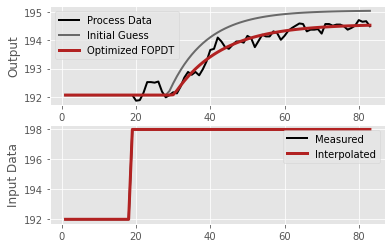

step response


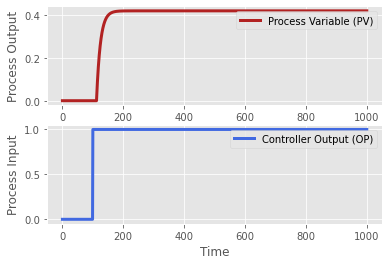

Initial SSE Objective: 64.47747403696172
Kc: 0.5
tauI: 10.0


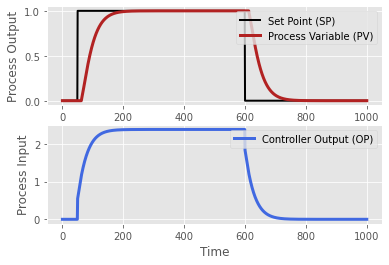

Final SSE Objective: 37.89054220397072
Kc: 2.2336457535495158
tauI: 14.839613300686748


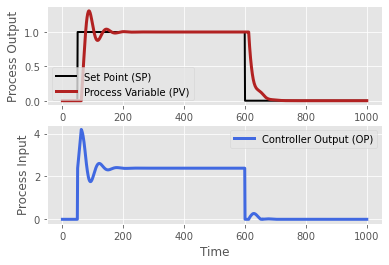

[2.2336457535495158, 148.39613300686747]


<Figure size 432x288 with 0 Axes>

In [56]:
data=pd.read_csv("Data2.csv")

tf=TF_fitting(data)
tf_p=tf.TF_fit()
pid_AT=PID_AutoTune()
PI=pid_AT.PID_opt()
print(PI)

In [57]:
PI

[2.2336457535495158, 148.39613300686747]

In [58]:
PI.append(2)

In [59]:
PI

[2.2336457535495158, 148.39613300686747, 2]